In [418]:
# Import libraries
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
%matplotlib inline
 

#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #initiating VADER instance
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [59]:
# Define a function that gives a sentiment score to text
def print_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)  #Calling the polarity analyzer
    print("{:-<40} {}".format(sentence, str(snt)))

In [419]:
# Download Airbnb listings database with full reviews for NYC, July 8 2019
Airbnb_listings_reviews = pd.read_csv('C:/Users/Yaarit/Documents/Insight/Insight_Project/Airbnb_reviews.csv',low_memory=False)

In [420]:
# Download Airbnb listings summary database for NYC, July 8 2019
Airbnb_listings_summary = pd.read_csv('C:/Users/Yaarit/Documents/Insight/Insight_Project/Airbnb_listings_summary.csv',low_memory=False)

In [421]:
# Download Airbnb listings database for NYC, July 8 2019
Airbnb_listings = pd.read_csv('C:/Users/Yaarit/Documents/Insight/Insight_Project/Airbnb_listings.csv',low_memory=False)

In [422]:
#Remove any duplicate row
Airbnb_listings_reviews.drop_duplicates(inplace=True)

In [423]:
#Remove any duplicate row
Airbnb_listings_summary.drop_duplicates(inplace=True)

In [424]:
#Remove any duplicate row
Airbnb_listings.drop_duplicates(inplace=True)

In [425]:
Airbnb_listings_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2539,55688172,12/4/2015,25160947,Peter,Great host
1,2539,97474898,8/27/2016,91513326,Liz,Nice room for the price. Great neighborhood. J...
2,2539,105340344,10/1/2016,90022459,Евгений,Very nice apt. New remodeled.
3,2539,133131670,2/20/2017,116165195,George,Great place to stay for a while. John is a gre...
4,2539,138349776,3/19/2017,118432644,Carlos,.


In [426]:
len(Airbnb_listings_reviews)

1048575

In [427]:
Airbnb_listings_reviews['comments'].isnull().sum()

457

In [428]:
Airbnb_listings_reviews['listing_id'].isnull().sum()

0

In [429]:
# Remove any listing that has a missing value
Airbnb_listings_reviews = Airbnb_listings_reviews.dropna()

In [430]:
# count the number of reviews
len(Airbnb_listings_reviews)

1048117

In [431]:
# Count the number of unique listings
len(Airbnb_listings_reviews.groupby(['listing_id']))

29247

In [432]:
# Define a bag of words that with high probablity indicate a review by a parent to young kids.
words_of_kids= ['baby', 'babies','toddler','toddlers', 'infant', 'infants', '1 year old', '2 year old', '3 year old', '4 year old', '5 year old', 'young kids', 'small kids','kiddie','kiddos', 'kiddo', 'preschooler','kindergartner']
# Find all reviews that are most likely parents reviews (according to the bag of words)
Airbnb_listings_reviews_parents = Airbnb_listings_reviews[Airbnb_listings_reviews.comments.str.contains('|'.join(words_of_kids ))]

In [433]:
# Remove reviews that included the phrase "like a baby", since this was written by people who slept like a baby and not by parents.
Airbnb_listings_reviews_parents = Airbnb_listings_reviews_parents[~Airbnb_listings_reviews_parents['comments'].str.contains("like a baby")]

In [434]:
Airbnb_listings_reviews_parents = Airbnb_listings_reviews_parents[~Airbnb_listings_reviews_parents['comments'].str.contains("like babies")]

In [435]:
# Count how many parents reviews
len(Airbnb_listings_reviews_parents)
# Unique list of listings with parents reviews
len(Airbnb_listings_reviews_parents.groupby(['listing_id']))

5206

In [471]:
# Creat a list of unique listings that do not have a parent review
Airbnb_listings_nonparents = pd.concat([Airbnb_listings_reviews['listing_id'].drop_duplicates(),Airbnb_listings_reviews_parents['listing_id'].drop_duplicates()])
Airbnb_listings_nonparents.drop_duplicates(keep=False, inplace = True)
len(Airbnb_listings_nonparents)

26220

In [492]:
# Take a sample of 2000 unique listings that did not have parent reviews (list of listings id)
sample_listings_nonparents = Airbnb_listings_nonparents.sample(n=2000, random_state=1)
sample_listings_nonparents.array

<PandasArray>
[25290572,  1745358, 26574893,  9412522, 16453520, 13044668,  9093389,
   157673, 19504985,  4786675,
 ...
  6325210, 21055153,  9637937,  4900034,  5999786,  8385108,  8865020,
   219066, 16334336, 24968131]
Length: 2000, dtype: int64

In [494]:
# Take a sample of 2000 unique listings that did have parent reviews (list of listings id)
Airbnb_listings_parents = Airbnb_listings_reviews_parents['listing_id'].drop_duplicates()
sample_listings_parents = Airbnb_listings_parents.sample(n=2000, random_state=1)
sample_listings_parents.array

<PandasArray>
[ 9611586, 26814763,  4760076,  6601284,  9522763,   618916,     7726,
  4933043,  5762947,  5418807,
 ...
 15564125, 15436836,    22911, 13042637,   193393,  1814279, 16380794,
 13757434,    17747,  1397705]
Length: 2000, dtype: int64

In [506]:
# Our sample from the data base is composed out of 2000 listings that had parent reviews and 2000 listings that did not have parent reviews
# There are 191,317 reviews in total to the listings with parents reviews, and 56,924 for listings without parent reviews.
# Our final sample includes 248,241 rows (comments) 
sample_listings_reviews = pd.concat([Airbnb_listings_reviews[Airbnb_listings_reviews['listing_id'].isin(sample_listings_nonparents.array)],Airbnb_listings_reviews[Airbnb_listings_reviews['listing_id'].isin(sample_listings_parents.array)] ])

In [507]:
# Compute the sentiment score to the reviews in our sample data

analyser = SentimentIntensityAnalyzer()

i=0 #counter

compval0 = [ ]  #empty list to hold our computed 'compound' VADER scores


while (i<len(sample_listings_reviews)):

    k = analyser.polarity_scores(sample_listings_reviews.iloc[i]['comments'])
    compval0.append(k['compound'])
    
    i = i+1
    
#converting sentiment values to numpy for easier usage

compval0 = np.array(compval0)

len(compval0)

248241

In [508]:
sample_listings_reviews['VADER score'] = compval0

In [509]:
sample_listings_reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments,VADER score
2371,7801,7026,8/9/2009,26220,Chi,We stayed at Chaya's place for a week with our...,0.9690
2372,7801,8317,8/26/2009,29070,Joshua & Gugulethu,This loft was incredible. I last lived in NYC...,0.9360
2373,7801,8591,8/30/2009,31599,Opal,Simply AWESOME! We felt right at home at Chaya...,0.9795
2374,7801,95077,9/12/2010,71624,Petina,Beautiful loft. The best place I've stayed in ...,0.9892
2375,7801,164512,1/3/2011,322540,Brent,"Nice place, and although I didn't meet Chaya, ...",0.7845
2376,7801,342116,6/29/2011,439195,Molly,Chaya's loft was in a perfect position for exp...,0.9830
2377,7801,488222,8/30/2011,703349,Les,The photos don't do Chaya's place justice! Wi...,0.9837
2378,7801,512801,9/8/2011,244926,Ross,Chaya's apartment is amazing and even nicer t...,0.9464
2379,7801,809746,12/28/2011,768779,Betsy,We loved Chaya's apartment. It is very well a...,0.9822
6365,15338,21612,12/28/2009,60438,Peter,I had a great stay at this place. Andrea and h...,0.9281


In [518]:
df = Airbnb_listings_reviews[Airbnb_listings_reviews['listing_id'].isin(Airbnb_listings_parents)].groupby('listing_id').count()

In [519]:
df.head()

,id,date,reviewer_id,reviewer_name,comments
listing_id,,,,,
2595,45,45,45,45,45
3831,270,270,270,270,270
5203,118,118,118,118,118
5803,167,167,167,167,167
7097,198,198,198,198,198


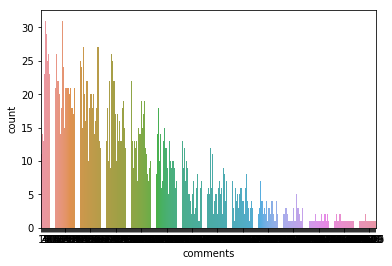

In [529]:
sns.countplot(x = 'comments', data=df)

In [525]:
df[(df['comments']<5)].count()

id               61
date             61
reviewer_id      61
reviewer_name    61
comments         61
dtype: int64